In [36]:
from statsbombpy import sb
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta


In [37]:
competitions = sb.competitions()

c:\Users\mathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [38]:
'''matches = sb.matches(competition_id=9, season_id=281).truncate(after=-1)

for index, competition in competitions.iterrows():
    if (competition["competition_gender"] != 'male' or 
        competition["competition_international"] == True or
        competition["competition_youth"] == True or
        competition["season_name"] != '2015/2016'
        ):
        continue
    matches = pd.concat([matches,sb.matches(competition_id=competition["competition_id"], season_id= competition["season_id"])])

matches.drop(["match_status_360","last_updated","last_updated_360","match_status","data_version","shot_fidelity_version","xy_fidelity_version"],axis=1, inplace=True)
matches['match_date'] = pd.to_datetime(matches['match_date'])
matches = matches.sort_values('match_date')'''

'matches = sb.matches(competition_id=9, season_id=281).truncate(after=-1)\n\nfor index, competition in competitions.iterrows():\n    if (competition["competition_gender"] != \'male\' or \n        competition["competition_international"] == True or\n        competition["competition_youth"] == True or\n        competition["season_name"] != \'2015/2016\'\n        ):\n        continue\n    matches = pd.concat([matches,sb.matches(competition_id=competition["competition_id"], season_id= competition["season_id"])])\n\nmatches.drop(["match_status_360","last_updated","last_updated_360","match_status","data_version","shot_fidelity_version","xy_fidelity_version"],axis=1, inplace=True)\nmatches[\'match_date\'] = pd.to_datetime(matches[\'match_date\'])\nmatches = matches.sort_values(\'match_date\')'

In [39]:
'''team_stats = pd.DataFrame()
# Initialize team_stats
team_stats = pd.DataFrame({
    'team': pd.concat([matches['home_team'], matches['away_team']]).unique(),
    'elo_rating': 1500,
    'total_games': 0,
    'total_wins': 0,
    'total_draws': 0,
    'total_lost': 0,
    'total_goals_scored': 0,
    'total_goals_conceded': 0,
}).set_index('team')

# Iterate over each match and update team_stats
for _, match in matches.iterrows():
    home_team = match['home_team']
    away_team = match['away_team']
    home_score = match['home_score']
    away_score = match['away_score']

    # Update wins/draws/losses
    if home_score > away_score:
        team_stats.loc[home_team, 'total_wins'] += 1
        team_stats.loc[away_team, 'total_lost'] += 1
    elif home_score < away_score:
        team_stats.loc[away_team, 'total_wins'] += 1
        team_stats.loc[home_team, 'total_lost'] += 1
    else:  # Draw
        team_stats.loc[home_team, 'total_draws'] += 1
        team_stats.loc[away_team, 'total_draws'] += 1
    
    # Update home team stats
    team_stats.loc[home_team, 'total_games'] += 1
    team_stats.loc[home_team, 'total_goals_scored'] += home_score
    team_stats.loc[home_team, 'total_goals_conceded'] += away_score
    
    # Update away team stats
    team_stats.loc[away_team, 'total_games'] += 1
    team_stats.loc[away_team, 'total_goals_scored'] += away_score
    team_stats.loc[away_team, 'total_goals_conceded'] += home_score

# Reset index for cleaner output
team_stats = team_stats.reset_index()
team_stats'''

"team_stats = pd.DataFrame()\n# Initialize team_stats\nteam_stats = pd.DataFrame({\n    'team': pd.concat([matches['home_team'], matches['away_team']]).unique(),\n    'elo_rating': 1500,\n    'total_games': 0,\n    'total_wins': 0,\n    'total_draws': 0,\n    'total_lost': 0,\n    'total_goals_scored': 0,\n    'total_goals_conceded': 0,\n}).set_index('team')\n\n# Iterate over each match and update team_stats\nfor _, match in matches.iterrows():\n    home_team = match['home_team']\n    away_team = match['away_team']\n    home_score = match['home_score']\n    away_score = match['away_score']\n\n    # Update wins/draws/losses\n    if home_score > away_score:\n        team_stats.loc[home_team, 'total_wins'] += 1\n        team_stats.loc[away_team, 'total_lost'] += 1\n    elif home_score < away_score:\n        team_stats.loc[away_team, 'total_wins'] += 1\n        team_stats.loc[home_team, 'total_lost'] += 1\n    else:  # Draw\n        team_stats.loc[home_team, 'total_draws'] += 1\n        te

In [40]:
'''# ELO parameters
K_FACTOR = 20
HOME_ADVANTAGE = 100

elo_history = []


elo_ratings = pd.Series(1500, index=team_stats['team'], name='elo_rating')


for idx, match in matches.iterrows():
    home_team = match['home_team']
    away_team = match['away_team']
    home_score = match['home_score']
    away_score = match['away_score']
    
    # Get current ratings with home advantage
    home_elo = elo_ratings[home_team] + HOME_ADVANTAGE
    away_elo = elo_ratings[away_team]
    
    # Calculate expected outcome (logistic function)
    expected_home = 1 / (1 + 10**((away_elo - home_elo)/400))
    expected_away = 1 - expected_home
    
    # Determine actual outcome
    if home_score > away_score:
        actual_home = 1
        actual_away = 0
    elif home_score < away_score:
        actual_home = 0
        actual_away = 1
    else:
        actual_home = 0.5
        actual_away = 0.5
    
    # Update ratings
    elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)
    elo_ratings[away_team] += K_FACTOR * (actual_away - expected_away)
    
    # Store historical ratings
    elo_history.append({
        'date': match['match_date'],
        'team': home_team,
        'elo': elo_ratings[home_team] - HOME_ADVANTAGE,  # Remove HA for storage
        'match_id': idx
    })
    elo_history.append({
        'date': match['match_date'],
        'team': away_team,
        'elo': elo_ratings[away_team],
        'match_id': idx
    })

# Convert history to DataFrame
elo_history_df = pd.DataFrame(elo_history)

# Merge final ratings with team_stats
team_stats['elo_rating'] = team_stats['team'].map(elo_ratings)'''

"# ELO parameters\nK_FACTOR = 20\nHOME_ADVANTAGE = 100\n\nelo_history = []\n\n\nelo_ratings = pd.Series(1500, index=team_stats['team'], name='elo_rating')\n\n\nfor idx, match in matches.iterrows():\n    home_team = match['home_team']\n    away_team = match['away_team']\n    home_score = match['home_score']\n    away_score = match['away_score']\n    \n    # Get current ratings with home advantage\n    home_elo = elo_ratings[home_team] + HOME_ADVANTAGE\n    away_elo = elo_ratings[away_team]\n    \n    # Calculate expected outcome (logistic function)\n    expected_home = 1 / (1 + 10**((away_elo - home_elo)/400))\n    expected_away = 1 - expected_home\n    \n    # Determine actual outcome\n    if home_score > away_score:\n        actual_home = 1\n        actual_away = 0\n    elif home_score < away_score:\n        actual_home = 0\n        actual_away = 1\n    else:\n        actual_home = 0.5\n        actual_away = 0.5\n    \n    # Update ratings\n    elo_ratings[home_team] += K_FACTOR * (ac

In [41]:
# 1. Sort team_stats by total_games (descending)
'''team_stats_sorted = team_stats.sort_values('total_games', ascending=False).head(20)

plt.figure(figsize=(10, 6))
bars = plt.bar(
    team_stats_sorted['team'],
    team_stats_sorted['total_games'],
    color='skyblue'
)

# 3. Customize the plot
plt.title('Total Games Played by Team', fontsize=14)
plt.xlabel('Team', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.xticks(rotation=45, ha='right')

# 4. Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()  # Prevent label cutoff
plt.show()'''

"team_stats_sorted = team_stats.sort_values('total_games', ascending=False).head(20)\n\nplt.figure(figsize=(10, 6))\nbars = plt.bar(\n    team_stats_sorted['team'],\n    team_stats_sorted['total_games'],\n    color='skyblue'\n)\n\n# 3. Customize the plot\nplt.title('Total Games Played by Team', fontsize=14)\nplt.xlabel('Team', fontsize=12)\nplt.ylabel('Number of Games', fontsize=12)\nplt.xticks(rotation=45, ha='right')\n\n# 4. Add value labels on top of bars\nfor bar in bars:\n    height = bar.get_height()\n    plt.text(\n        bar.get_x() + bar.get_width()/2.,\n        height,\n        f'{int(height)}',\n        ha='center',\n        va='bottom'\n    )\n\nplt.tight_layout()  # Prevent label cutoff\nplt.show()"

c:\Users\mathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\mathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\mathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\mathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\mathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\mathi\AppData\Local\Programs\Python\Python311\Lib\s

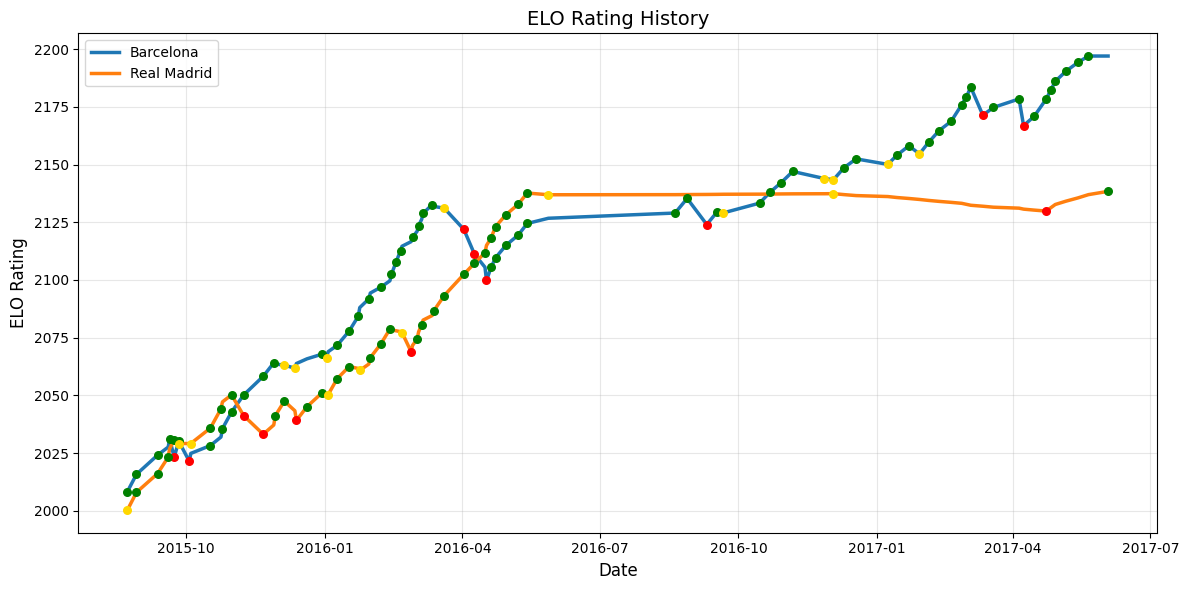

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1991.16' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


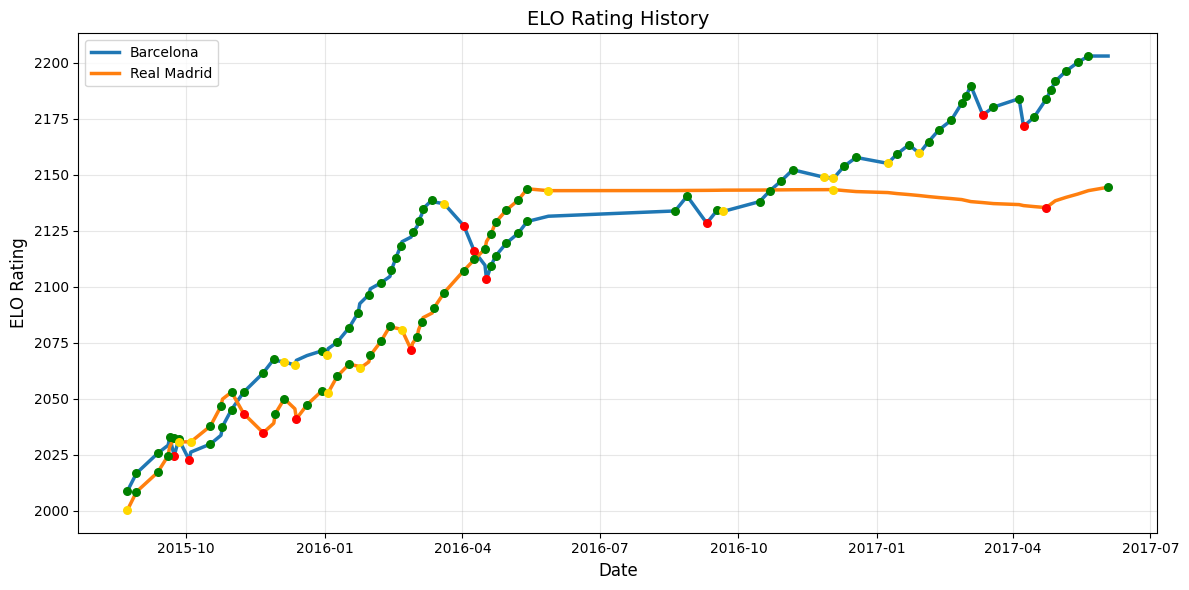

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1990.64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


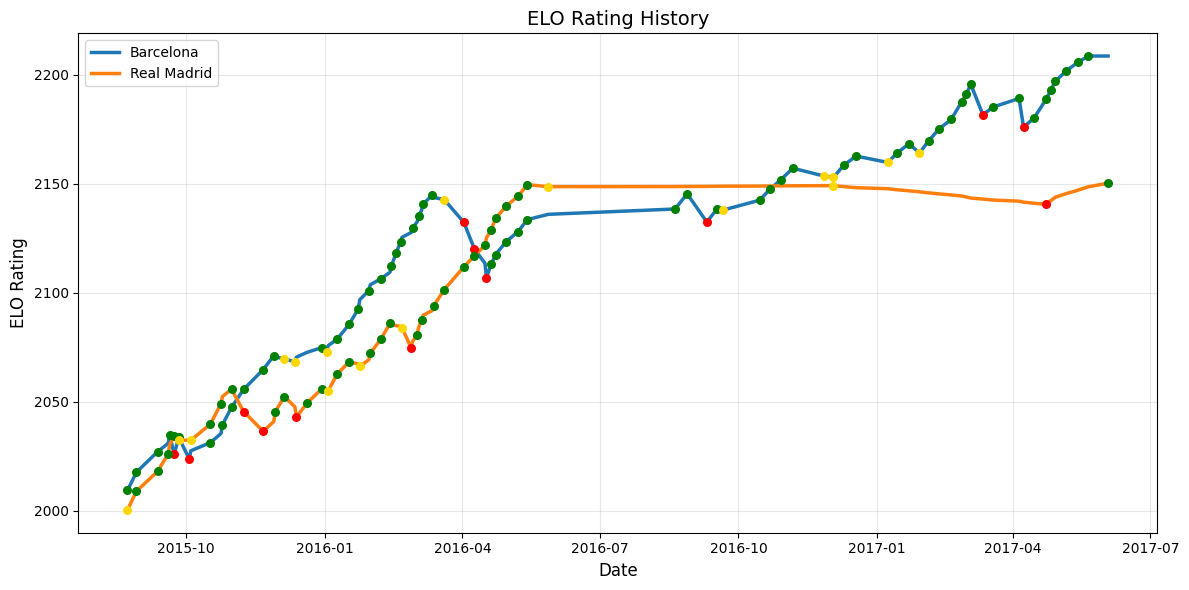

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1990.12' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


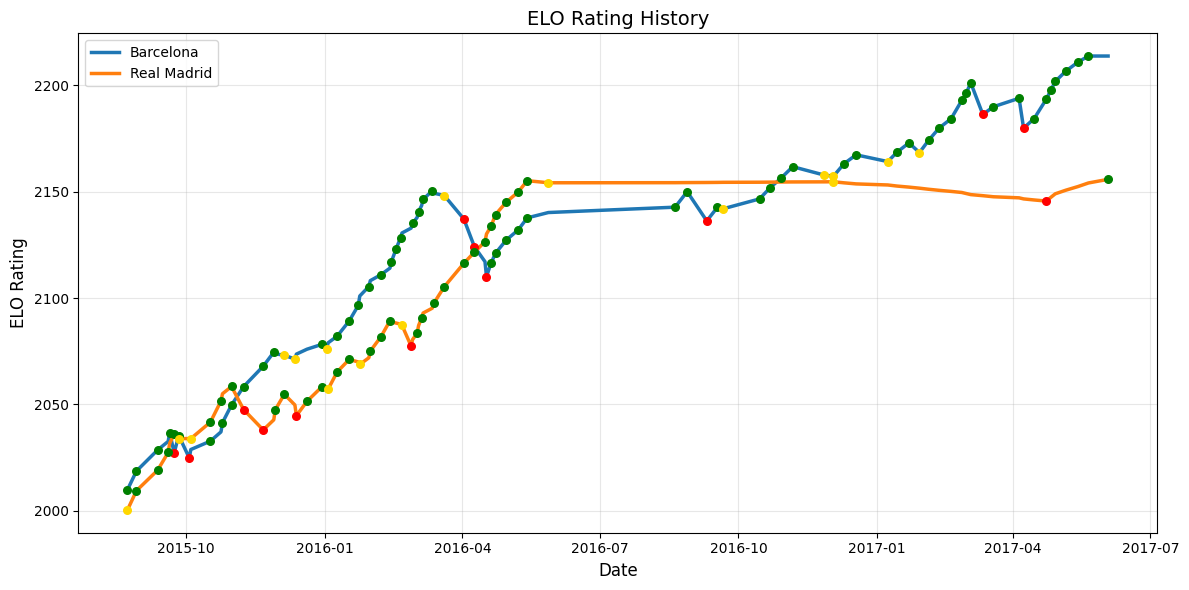

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1989.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


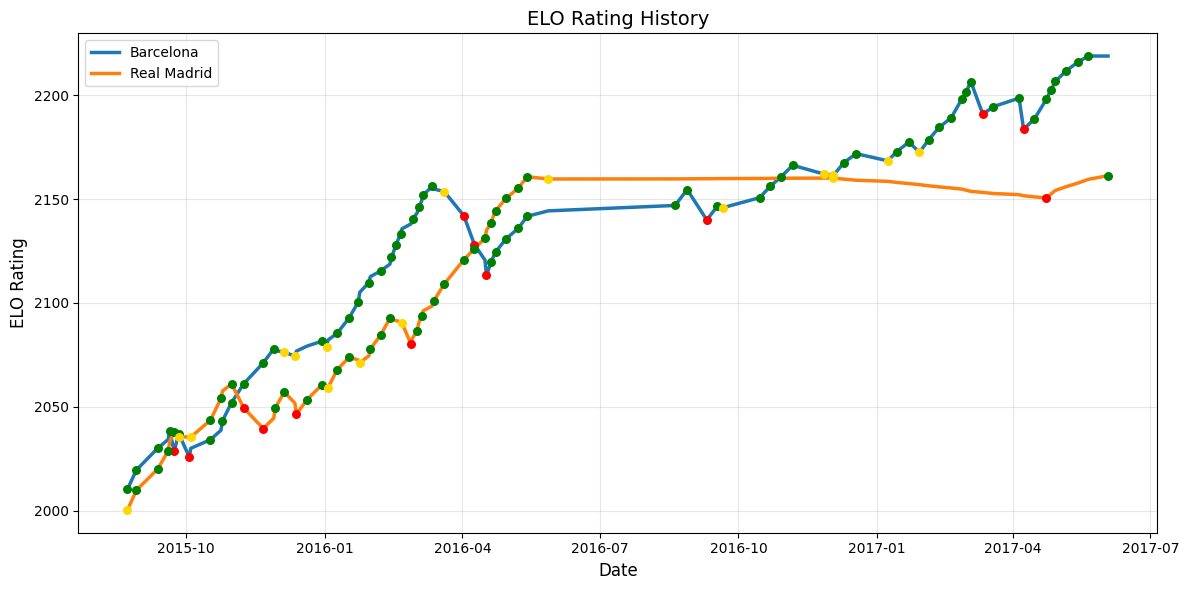

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1989.08' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


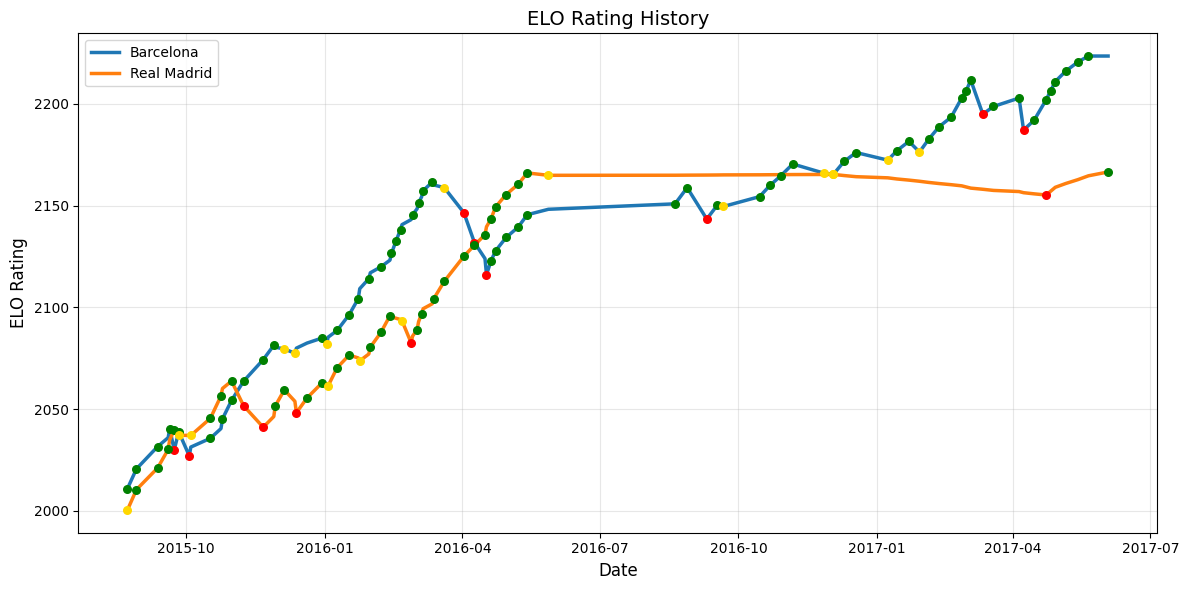

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1988.56' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


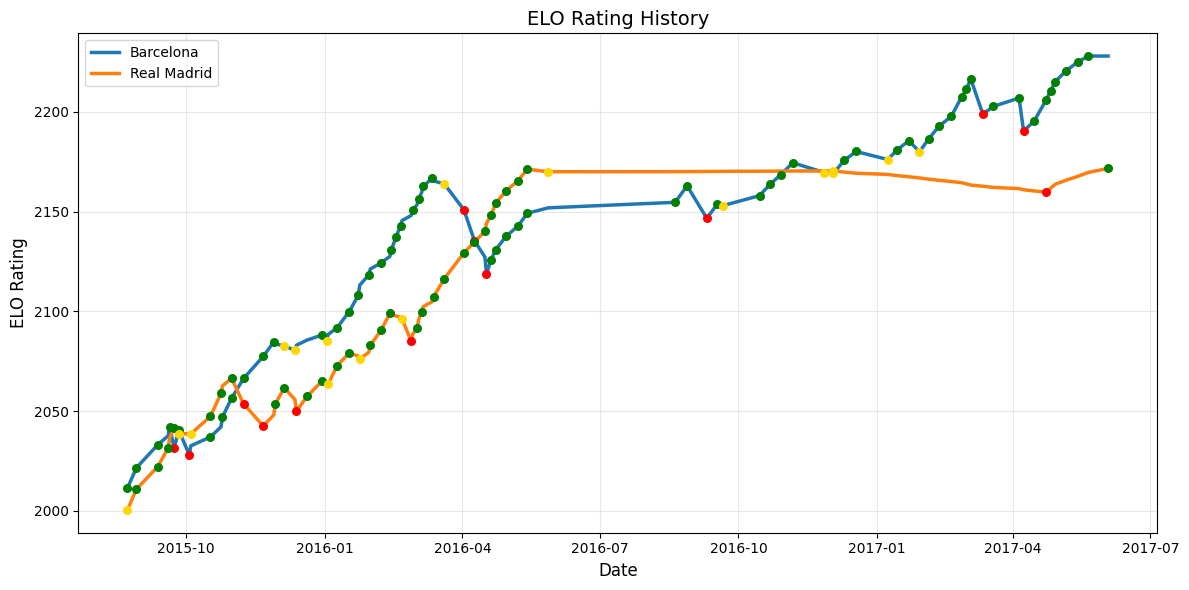

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1988.04' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


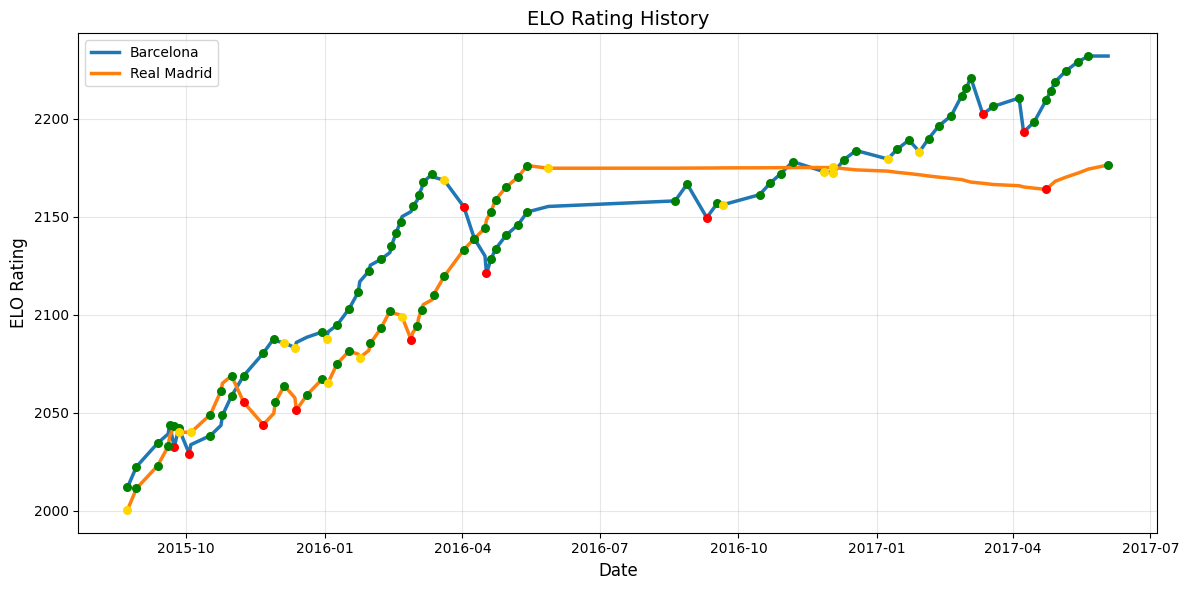

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1987.52' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


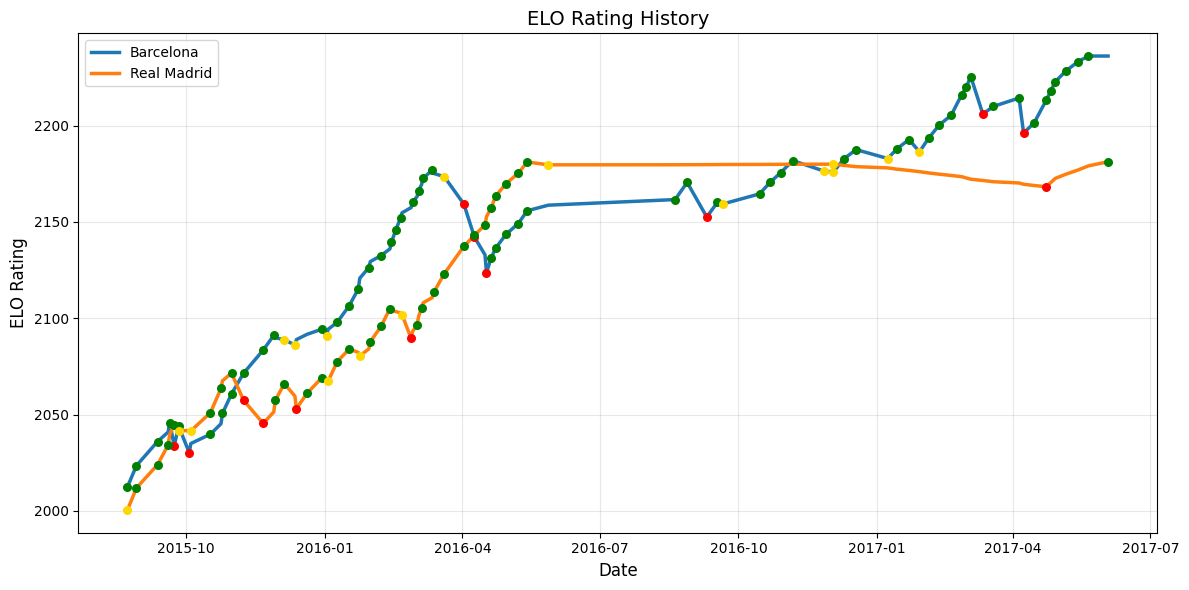

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1999.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


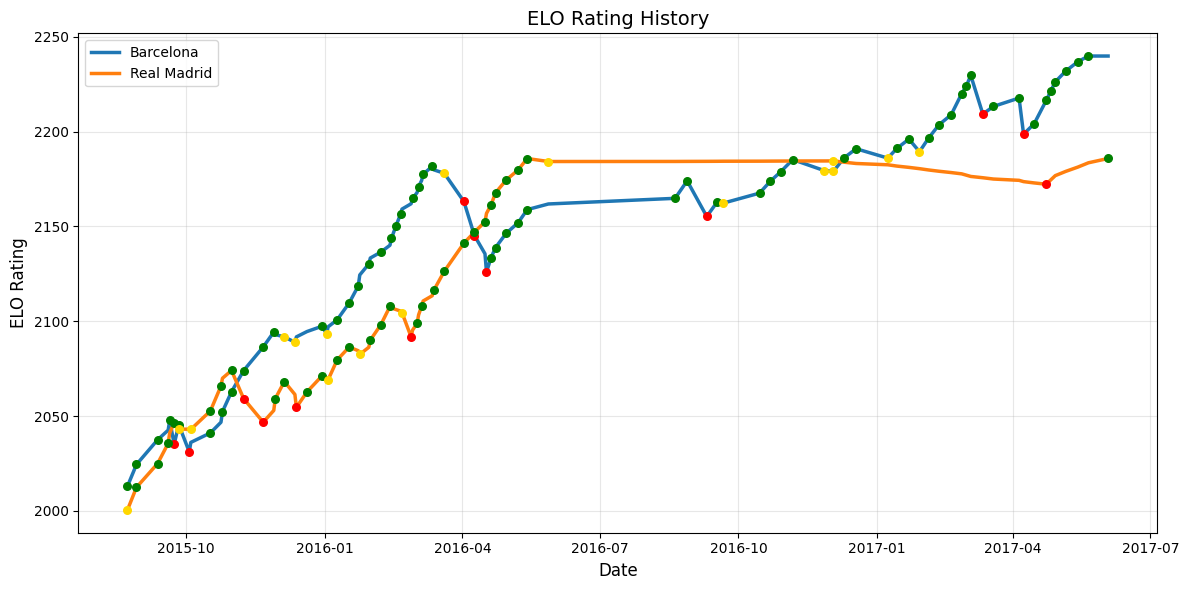

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1986.48' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


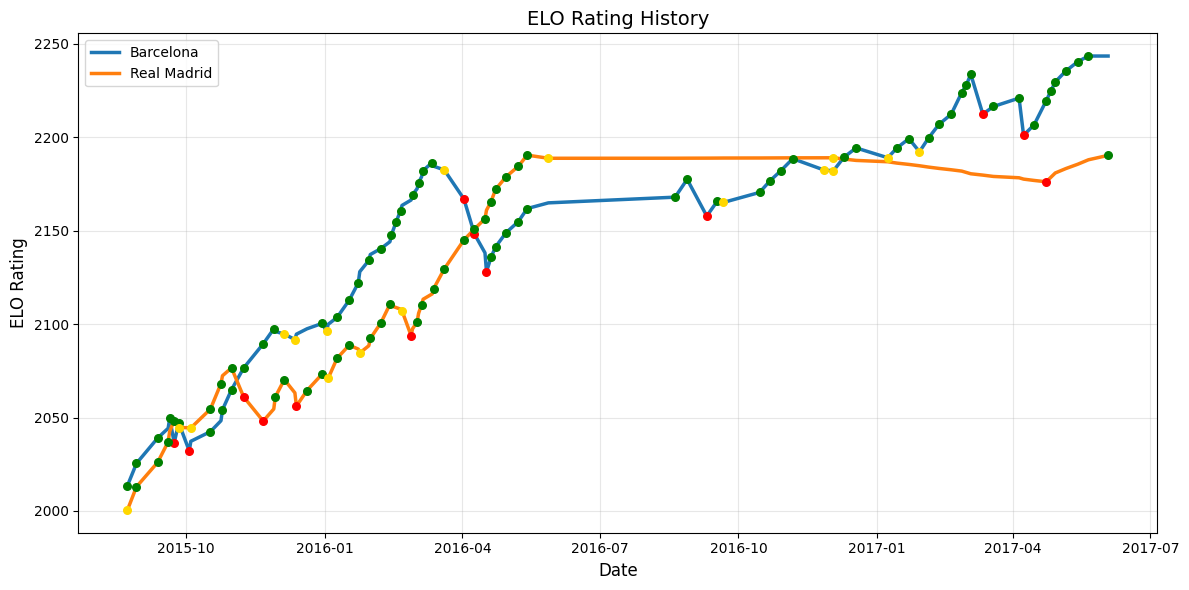

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1985.96' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


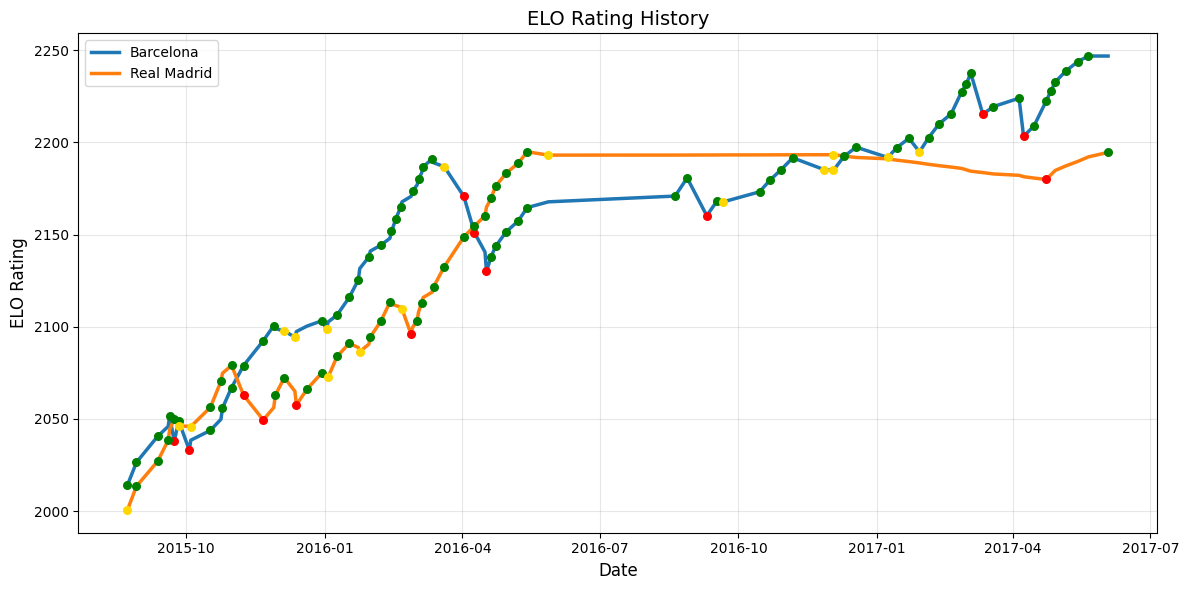

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1985.44' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


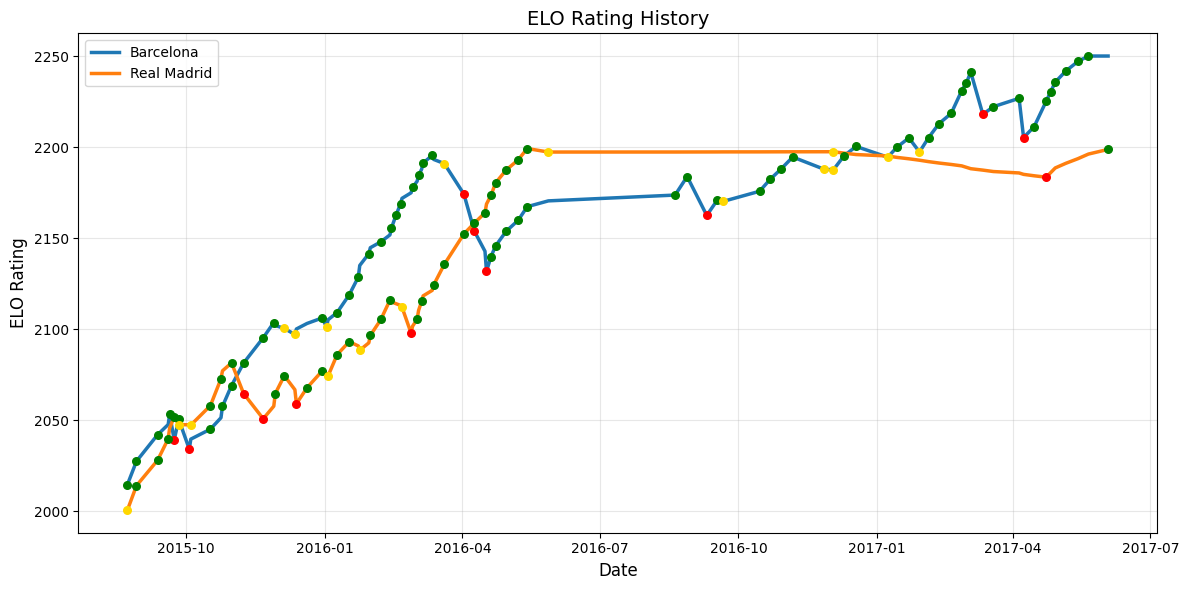

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1984.92' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


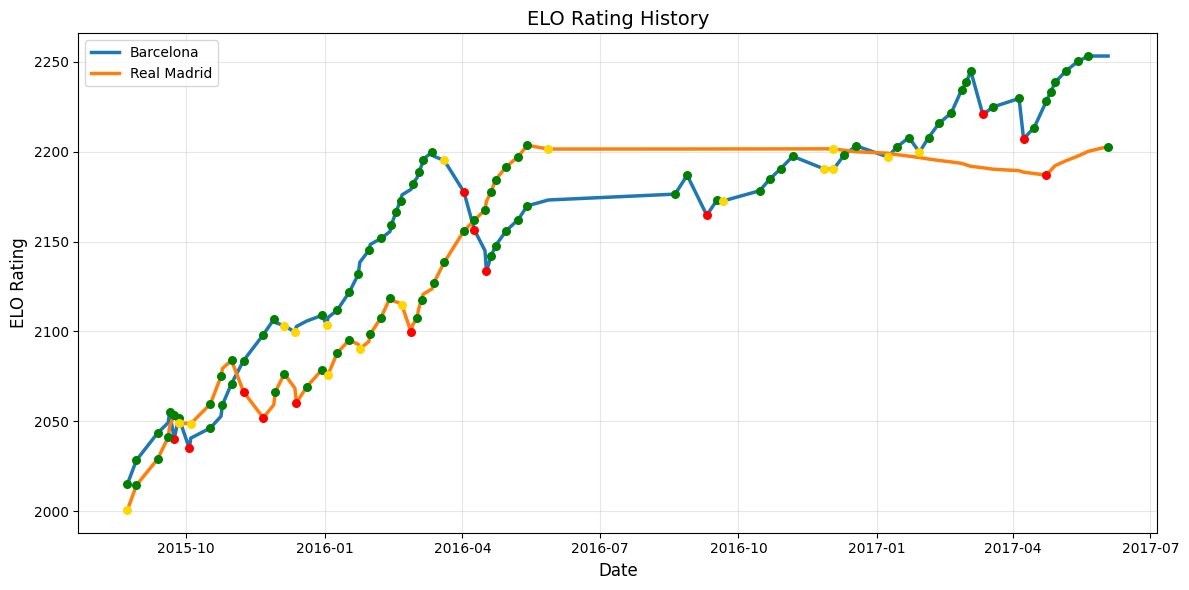

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1984.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


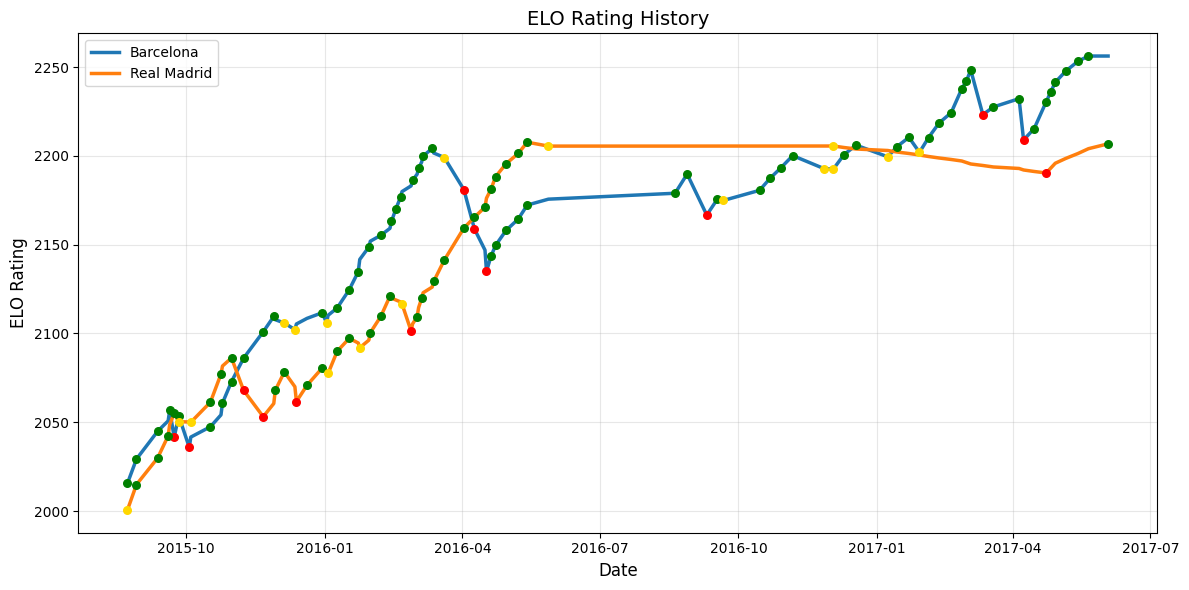

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1983.88' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


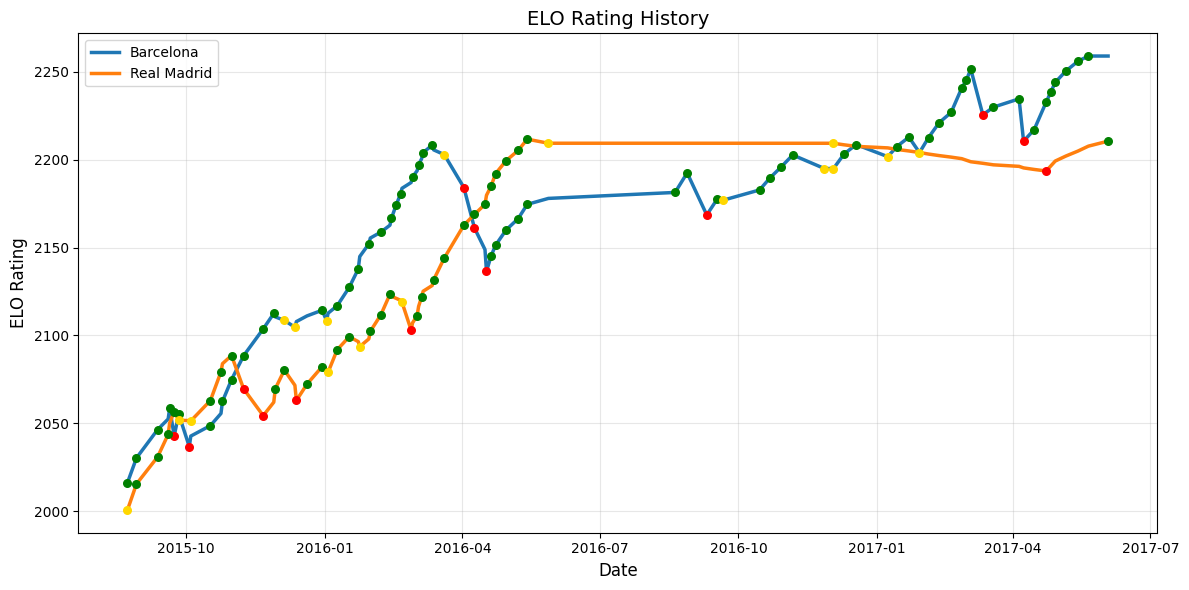

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1983.36' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


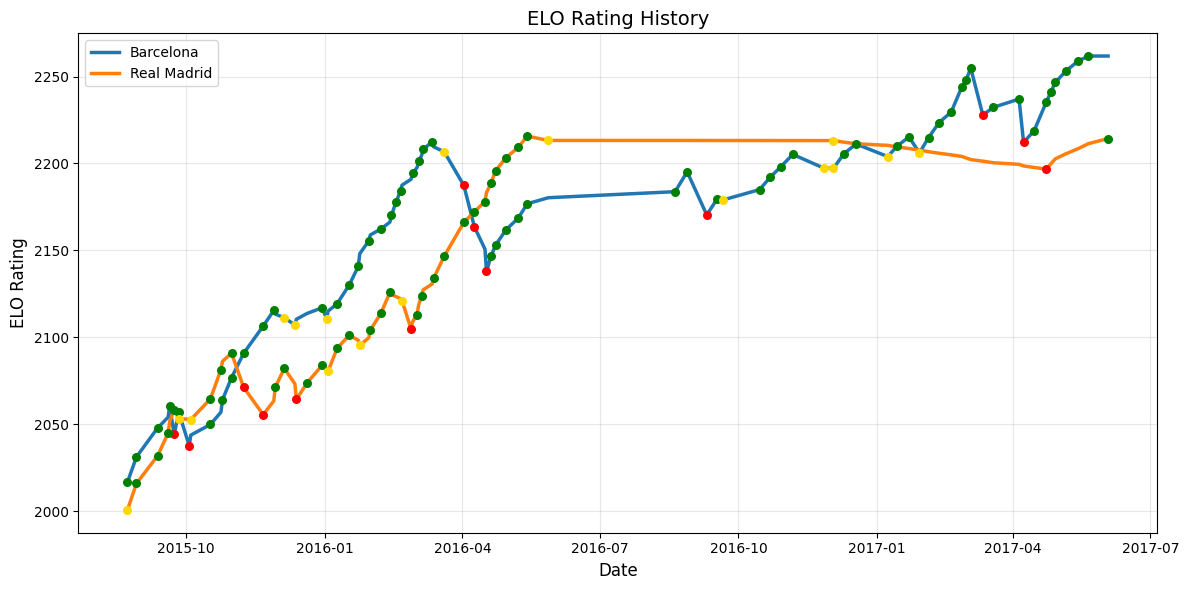

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1982.84' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


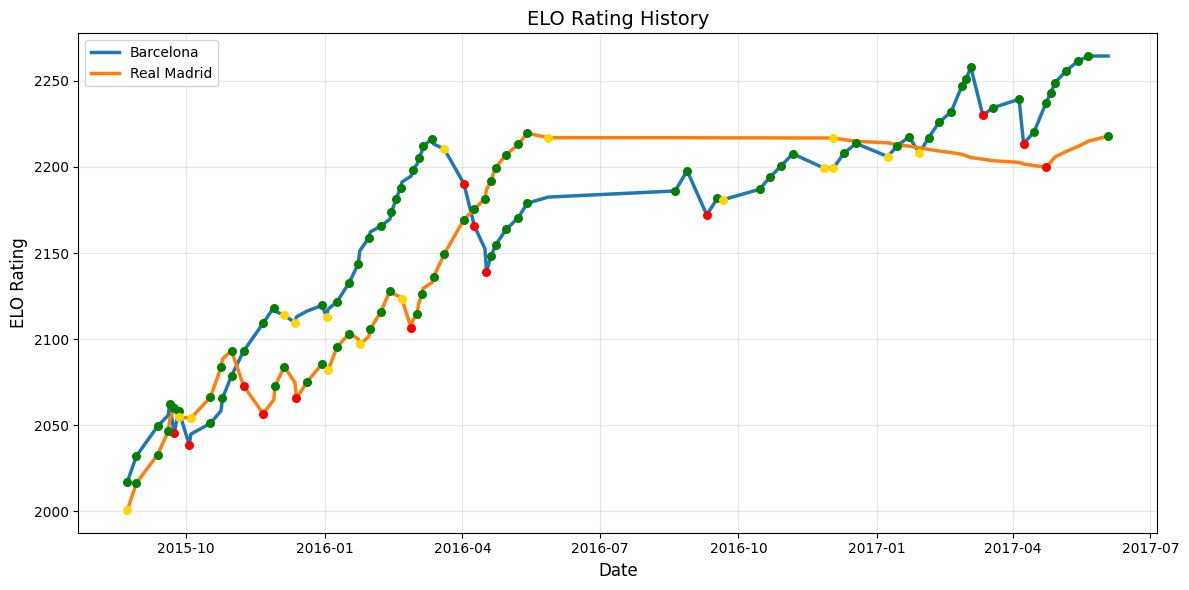

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1982.32' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


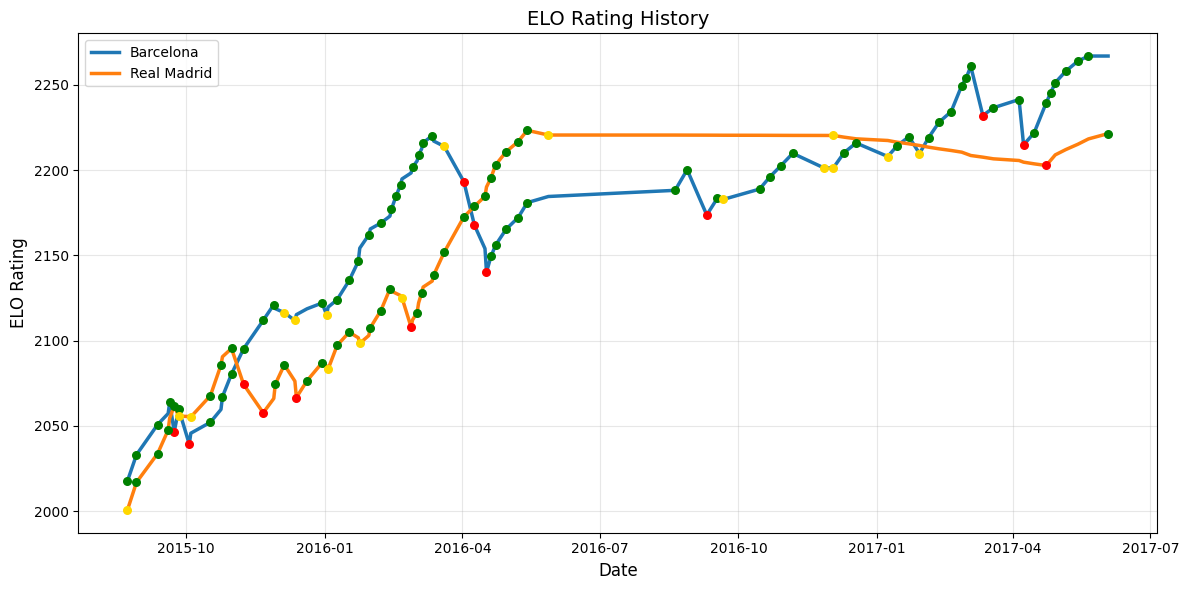

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1981.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


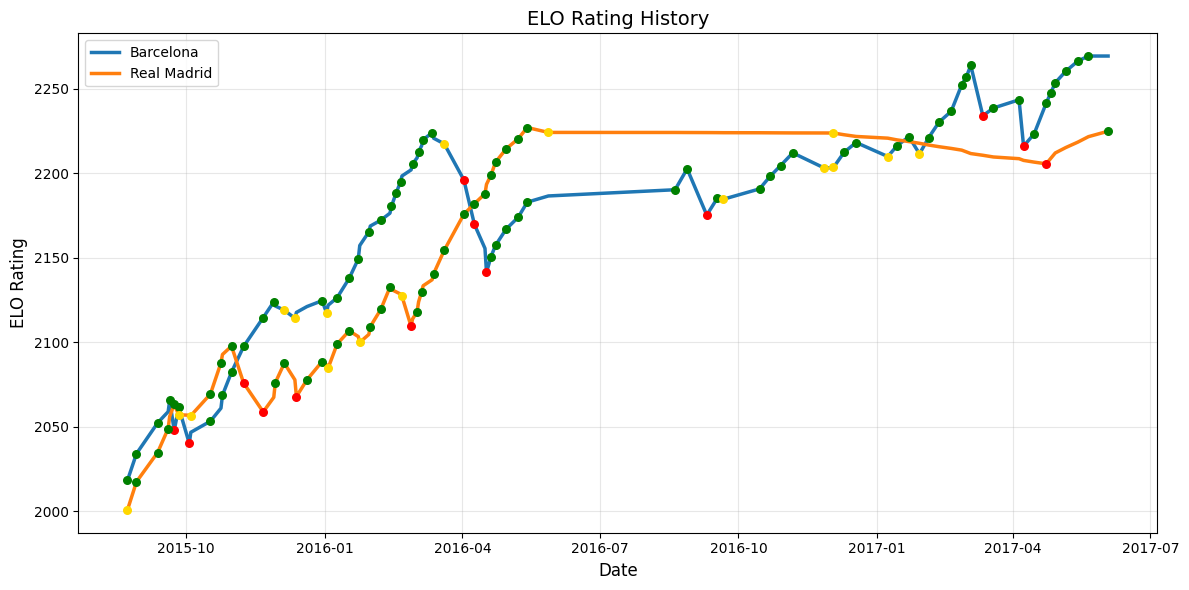

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1981.28' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


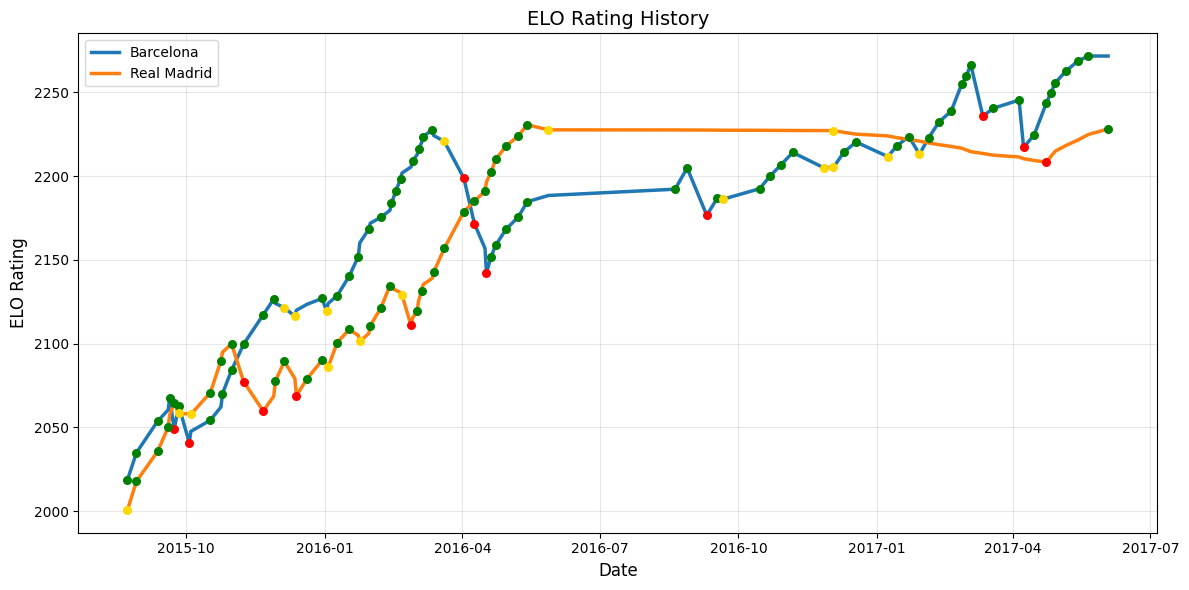

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1980.76' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


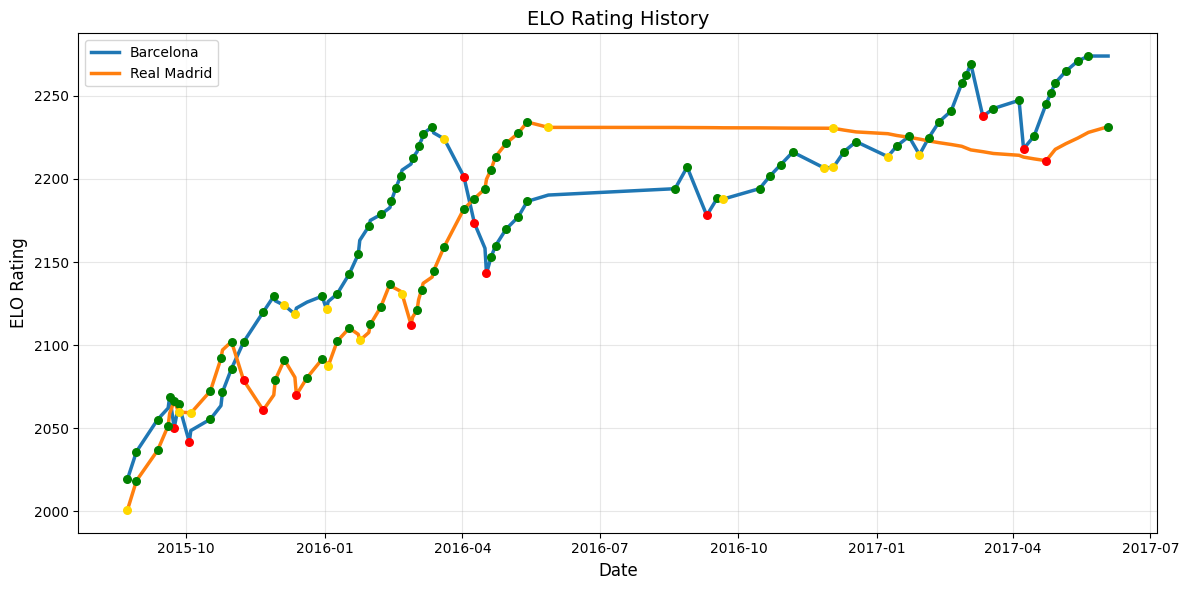

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1980.24' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


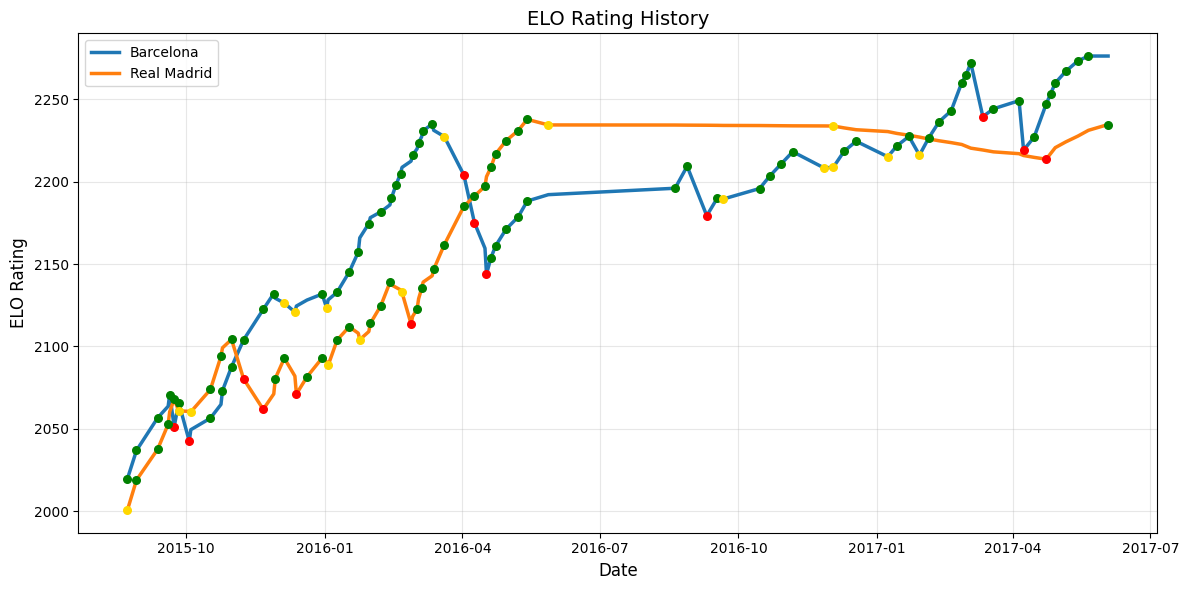

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1979.72' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


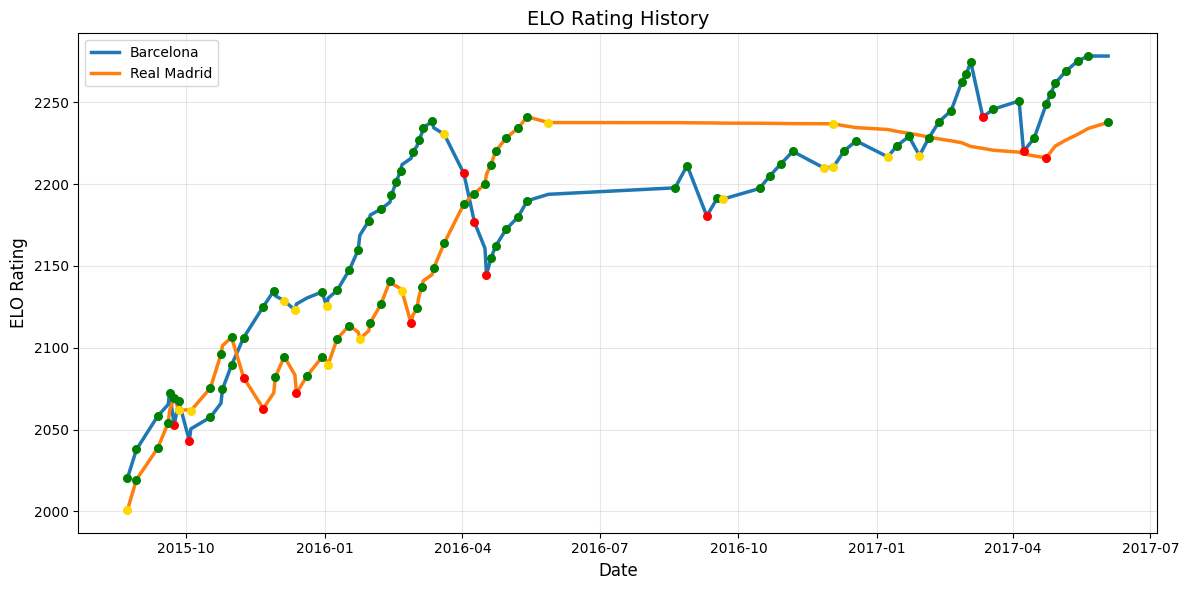

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1979.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


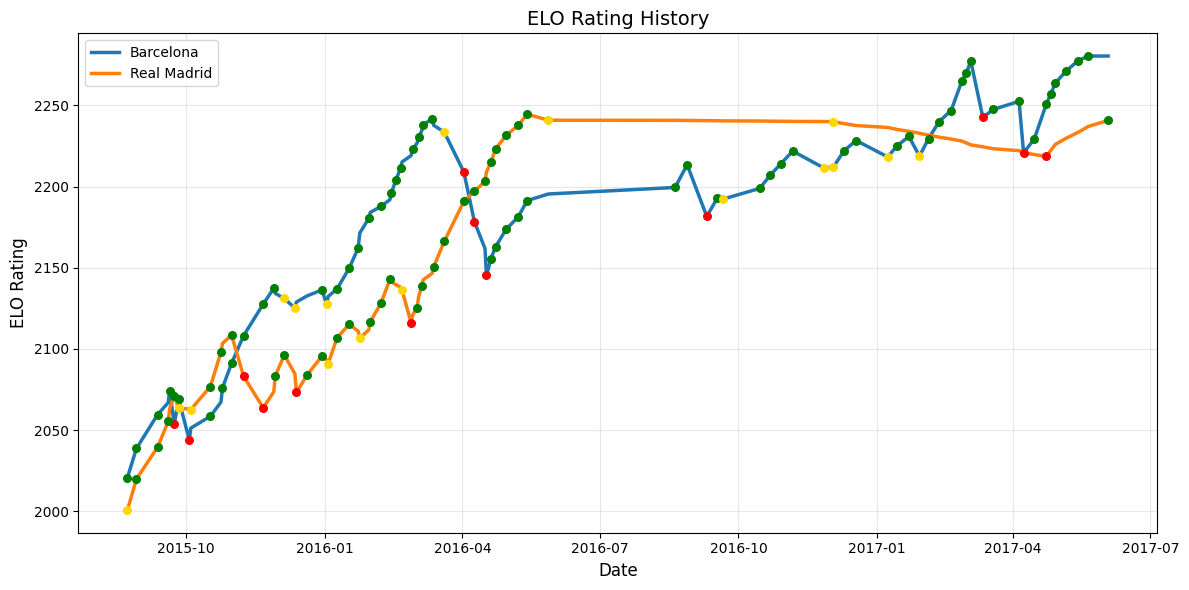

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1978.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


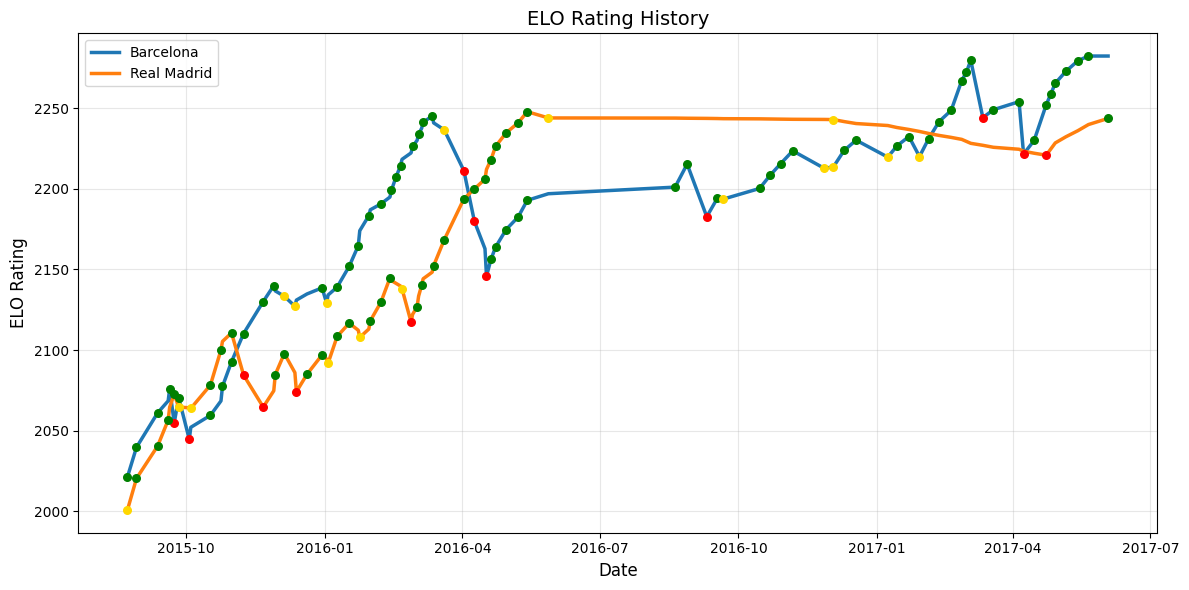

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1978.16' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


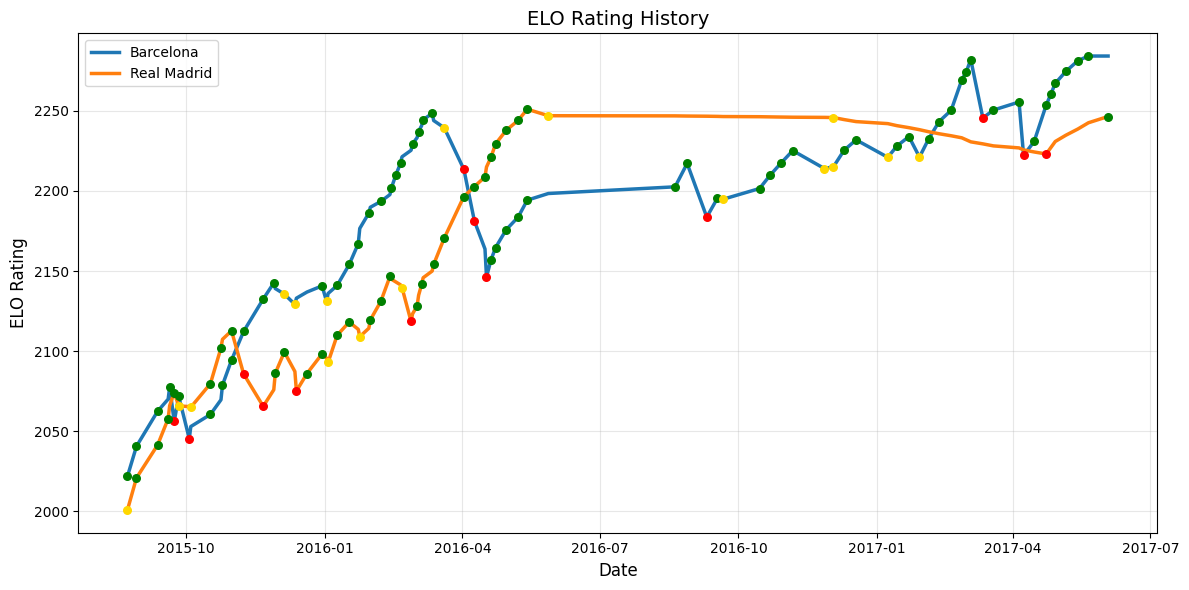

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1977.64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


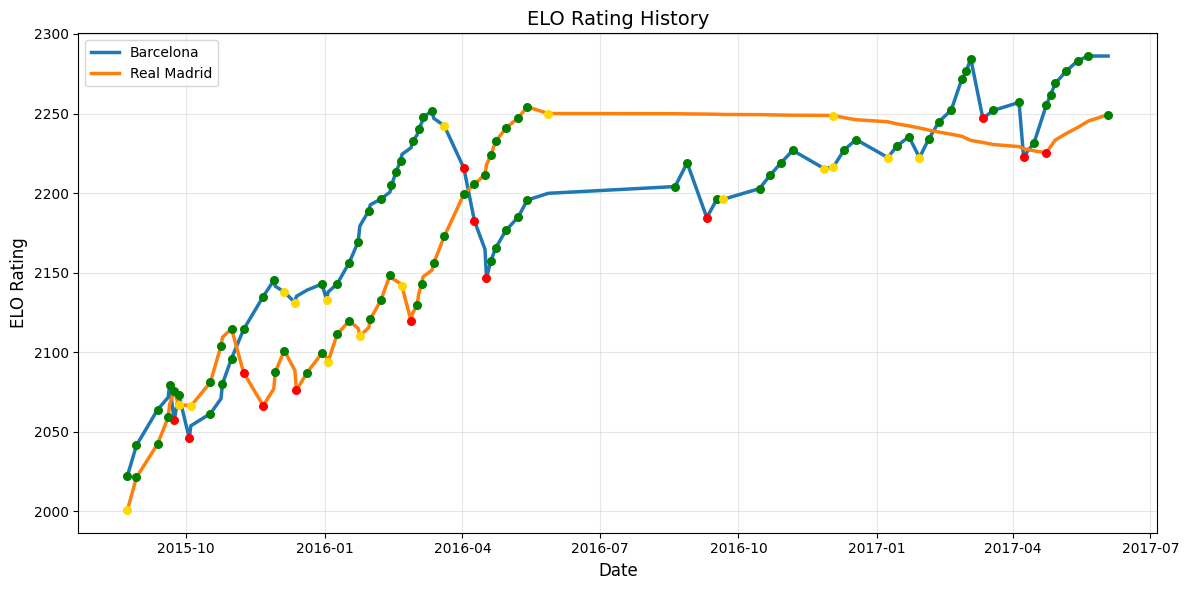

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1977.12' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


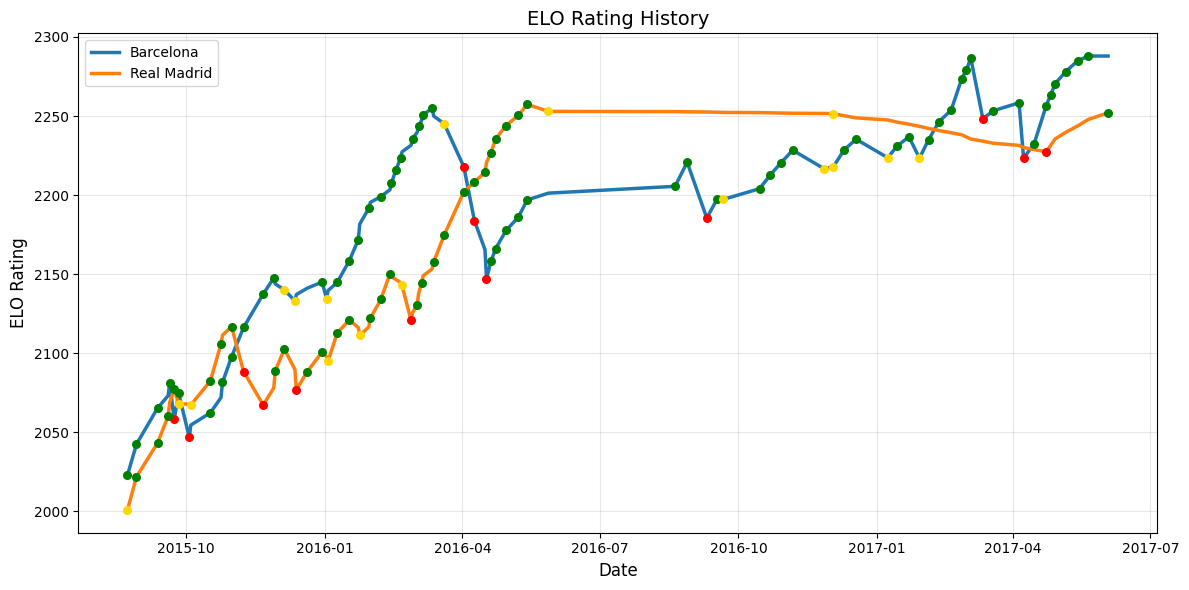

C:\Users\mathi\AppData\Local\Temp\ipykernel_8416\3510815565.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1976.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


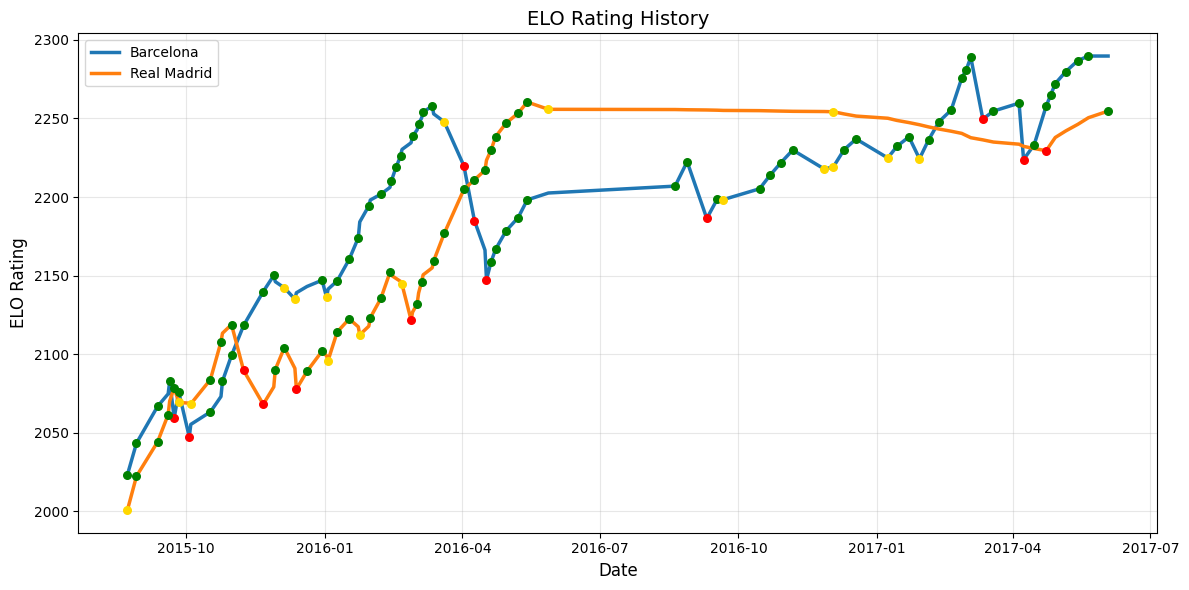

In [59]:
matches = sb.matches(competition_id=9, season_id=281).truncate(after=-1)

for index, competition in competitions.iterrows():
    if (competition["competition_gender"] != 'male' or 
        competition["competition_international"] == True or
        competition["competition_youth"] == True or
        competition["season_name"] not in ['2015/2016', '2016/2017']
        ):
        continue
    matches = pd.concat([matches,sb.matches(competition_id=competition["competition_id"], season_id= competition["season_id"])])

matches.drop(["match_status_360","last_updated","last_updated_360","match_status","data_version","shot_fidelity_version","xy_fidelity_version"],axis=1, inplace=True)
matches['match_date'] = pd.to_datetime(matches['match_date'])
matches = matches.sort_values('match_date')

team_stats = pd.DataFrame()
# Initialize team_stats
team_stats = pd.DataFrame({
    'team': pd.concat([matches['home_team'], matches['away_team']]).unique(),
    'elo_rating': 2000,
    'total_games': 0,
    'total_wins': 0,
    'total_draws': 0,
    'total_lost': 0,
    'total_goals_scored': 0,
    'total_goals_conceded': 0,
}).set_index('team')

# Iterate over each match and update team_stats
for _, match in matches.iterrows():
    home_team = match['home_team']
    away_team = match['away_team']
    home_score = match['home_score']
    away_score = match['away_score']

    # Update wins/draws/losses
    if home_score > away_score:
        team_stats.loc[home_team, 'total_wins'] += 1
        team_stats.loc[away_team, 'total_lost'] += 1
    elif home_score < away_score:
        team_stats.loc[away_team, 'total_wins'] += 1
        team_stats.loc[home_team, 'total_lost'] += 1
    else:  # Draw
        team_stats.loc[home_team, 'total_draws'] += 1
        team_stats.loc[away_team, 'total_draws'] += 1
    
    # Update home team stats
    team_stats.loc[home_team, 'total_games'] += 1
    team_stats.loc[home_team, 'total_goals_scored'] += home_score
    team_stats.loc[home_team, 'total_goals_conceded'] += away_score
    
    # Update away team stats
    team_stats.loc[away_team, 'total_games'] += 1
    team_stats.loc[away_team, 'total_goals_scored'] += away_score
    team_stats.loc[away_team, 'total_goals_conceded'] += home_score

# Reset index for cleaner output
team_stats = team_stats.reset_index()
team_stats


K_FACTOR = 15
HOME_ADVANTAGE = 0.02
AWAY_DISADVANTAGE = - HOME_ADVANTAGE

for x in range(30):
    elo_history = []
    K_FACTOR += 1

    elo_ratings = pd.Series(2000, index=team_stats['team'], name='elo_rating')

    for idx, match in matches.iterrows():
        home_team = match['home_team']
        away_team = match['away_team']
        home_score = match['home_score']
        away_score = match['away_score']
        
        home_elo = elo_ratings[home_team] 
        away_elo = elo_ratings[away_team]
        
        expected_home = (1 / (1 + 10**((away_elo - home_elo) / 400))) + HOME_ADVANTAGE 
        expected_away = 1 - expected_home
        
        if home_score > away_score:
            actual_home = 1
            actual_away = 0
            home_result = 'win'
            away_result = 'loss'
        elif home_score < away_score:
            actual_home = 0
            actual_away = 1
            home_result = 'loss'
            away_result = 'win'
        else:
            actual_home = 0.5
            actual_away = 0.5
            home_result = 'draw'
            away_result = 'draw'

        elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)
        elo_ratings[away_team] += K_FACTOR * (actual_away - expected_away)

        # Append result and Elo to history
        elo_history.append({
            'date': match['match_date'],  # for pivoting and Elo logic
            'plot_date': match['match_date'],  # for plotting
            'team': home_team,
            'elo': elo_ratings[home_team] ,#- HOME_ADVANTAGE,
            'match_id': idx,
            'result': home_result
        })
        elo_history.append({
            'date': match['match_date'],
            'plot_date': match['match_date'] + timedelta(minutes=5),  # slight offset for dot
            'team': away_team,
            'elo': elo_ratings[away_team],
            'match_id': idx,
            'result': away_result
        })

    elo_history_df = pd.DataFrame(elo_history)
    team_stats['elo_rating'] = team_stats['team'].map(elo_ratings)

    selected_teams = ['Barcelona', 'Real Madrid']
    team_history = elo_history_df[elo_history_df['team'].isin(selected_teams)]
    team_history = team_history[team_history['date'] > '2000-12-31']

    elo_pivot = team_history.pivot(index='date', columns='team', values='elo')
    elo_pivot = elo_pivot.sort_index().interpolate()

    plt.figure(figsize=(12, 6))

    result_colors = {'win': 'green', 'loss': 'red', 'draw': 'gold'}

    for team in selected_teams:
        plt.plot(elo_pivot.index, elo_pivot[team], label=team, linewidth=2.5)

        team_points = team_history[team_history['team'] == team]
        for _, row in team_points.iterrows():
            plt.scatter(row['plot_date'], row['elo'], color=result_colors[row['result']], s=30, zorder=5)


    plt.title('ELO Rating History', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('ELO Rating', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


